In [270]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from camera_utils import fix_barrel_distortion

(4272, 2848, 3)


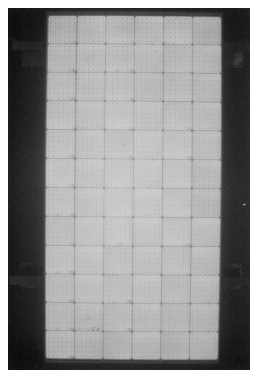

In [271]:
image = cv2.imread("C:/Users/chuck/OneDrive/Desktop/Honors/EL_images/Q72712M1801AJO0421_IMG_8916.JPG")
# image = cv2.imread("C:/Users/chuck/OneDrive/Desktop/Honors/BT1/BT1/F52J01525101_IMG_8993.JPG")
# image = cv2.imread("C:/Users/chuck/OneDrive/Desktop/Honors/EL_images/Q72712M1802ARK1119_IMG_8918.JPG")

print(image.shape)
plt.figure(figsize=(8, 6), dpi=80)
plt.axis('off')
plt.imshow(image)

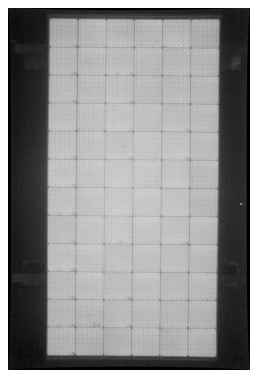

In [272]:
toml_path = "C:/Users/chuck/OneDrive/Desktop/Honors/solarEL/solarel/configs/camera_config.toml"
image = fix_barrel_distortion(image, toml_path)
plt.figure(figsize=(8, 6), dpi=80)
plt.axis('off')
plt.imshow(image)

[0 0 0 ... 0 0 0]


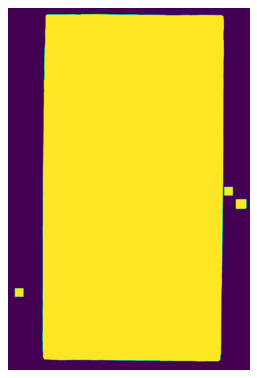

In [273]:
image_cp = np.copy(image)
image_cp = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image_cp = cv2.blur(image_cp, (5,5))
avg_intensity = int(cv2.mean(image)[0])

_, thresh = cv2.threshold(image_cp, int(avg_intensity*0.8), 255, cv2.THRESH_BINARY)

kernel = np.ones((100,100), np.uint8)
dilated = cv2.dilate(thresh, kernel, iterations=1)
print(dilated[0])

plt.figure(figsize=(8, 6), dpi=80)
plt.axis('off')
plt.imshow(dilated)

4


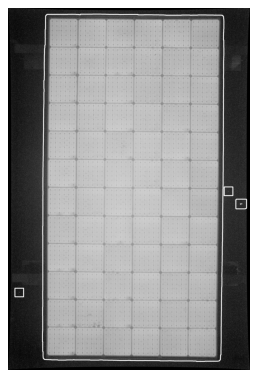

In [274]:
contours, hierarchy = cv2.findContours(dilated,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
print(len(contours))
image_cp = np.copy(image)
image_cp = cv2.drawContours(image_cp, contours, -1, (255,255,255), 10)
plt.figure(figsize=(8, 6), dpi=80)
plt.axis('off')
plt.imshow(image_cp)

In [275]:
def largest_rectangle(contours):
    # Approximate contours to polygons and find the largest rectangle
    largest_rect = None
    max_area = 0
    for cnt in contours:
        # Approximate the contour to a polygon
        poly = cv2.approxPolyDP(cnt, 0.03*cv2.arcLength(cnt,True), True)
        # If the polygon has 4 vertices (is a rectangle)
        if len(poly) == 4:
            # Calculate the area of the polygon
            area = cv2.contourArea(poly)
            # If the area is larger than the current maximum
            if area > max_area:
                # Update the maximum area and largest rectangle
                max_area = area
                largest_rect = poly
    # Return the largest rectangle
    return largest_rect

rect = largest_rectangle(contours)
# Convert the list of points to a numpy array
rect = np.array(rect)
x, y, w, h = cv2.boundingRect(rect)
rect = np.array([[x, y], [x, y+h], [x+w, y+h], [x+w, y]])
print(rect)
# Reshape the array to a 1D array of (x, y) tuples
points = rect.reshape(-1, 2)
src_pts = np.float32(points)

[[ 414   86]
 [ 414 4167]
 [2533 4167]
 [2533   86]]


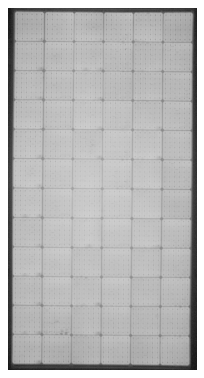

In [276]:
dest_pts = np.float32([[0, 0], [0, h], [w, h], [w, 0]])

M = cv2.getPerspectiveTransform(src_pts, dest_pts)
image_cp = np.copy(image)
# Apply the perspective transform to the image
cropped = cv2.warpPerspective(image_cp, M, (w, h))
plt.figure(figsize=(8, 6), dpi=80)
plt.axis('off')
plt.imshow(cropped)

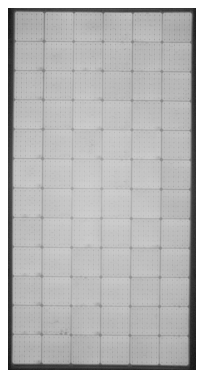

In [277]:
def scale_image(image, scale_factor):
    # Calculate the new dimensions of the image
    new_width = int(image.shape[1] * scale_factor)
    new_height = int(image.shape[0] * scale_factor)

    # Resize the image using the new dimensions
    return cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)

cropped_cp = np.copy(cropped)
scale_factor = 0.2
cropped_cp = scale_image(cropped_cp, scale_factor)

plt.figure(figsize=(8, 6), dpi=80)
plt.axis('off')
plt.imshow(cropped_cp)

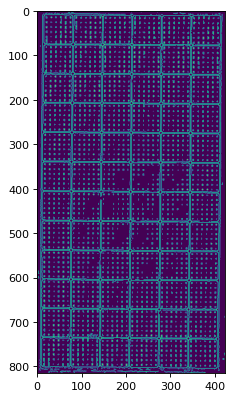

In [278]:
edges = cv2.Canny(cropped_cp, 70, 110)

_, thresh = cv2.threshold(cropped_cp, 195, 255, cv2.THRESH_BINARY)

plt.figure(figsize=(8, 6), dpi=80)
plt.imshow(edges)

In [279]:
def horz_hough_lines(edges, votes, pixels):
    lines = None
    while lines is None:
        lines = cv2.HoughLines(edges, pixels, np.pi/90, votes)
        votes = int(votes*0.95)
        
    good_lines = []
    # Loop over the detected lines
    for line in lines:
        _, theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        slope = - a / b if b != 0 else 100 # divide by zero saftey
        # Check if the line is approximately horizontal
        if abs(slope)<0.2:
            good_lines.append(line)
    return good_lines

def vert_hough_lines(edges, votes, pixels):
    lines = None
    while lines is None:
        lines = cv2.HoughLines(edges, pixels, np.pi/90, votes)
        votes = int(votes*0.95)

    good_lines = []
    # Loop over the detected lines
    for line in lines:
        _, theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        slope = - a / b if b != 0 else 100 # divide by zero saftey
        # Check if the line is approximately horizontal
        if abs(slope)>50:
            good_lines.append(line)
    return good_lines

def draw_hough_lines(image, hough_lines):
    # Loop over the detected lines
    for line in hough_lines:
        rho, theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        cv2.line(image, (x1, y1), (x2, y2), (255, 255, 255), 2)
    return image

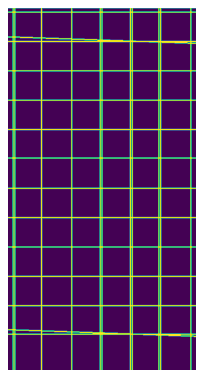

In [284]:
horz_lines = horz_hough_lines(edges, 230, 2)
vert_lines = vert_hough_lines(edges, 620, 2)
lines = horz_lines + vert_lines

edges_cp = np.copy(edges) * 0
cells = draw_hough_lines(edges_cp, lines)

plt.figure(figsize=(8, 6), dpi=80)
plt.axis('off')
plt.imshow(cells)